## Taller 6 - Punto 2

In [1]:
#Importamos librerías
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

In [2]:
# Cargamos los datos
df1 = pd.read_csv('heart.csv')

In [3]:
df1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [4]:
# Identificamos N/A
df1.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
df1["thal"].unique()

array(['fixed', 'normal', 'reversible', '1', '2'], dtype=object)

In [6]:
df1 = df1[~df1['thal'].str.isdigit()]
df1['thal'].unique()

array(['fixed', 'normal', 'reversible'], dtype=object)

In [7]:
# Ordenamos los datos

cat_int_feats = ['sex', 'cp', 'fbs', 'exang', 'ca']
cat_str_feats = ['thal']
num_feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
feats_ordered = cat_int_feats+cat_str_feats+num_feats

In [8]:
df1 = df1[feats_ordered+['target']]

In [9]:
# Separamos datos de train
train = df1.sample(frac=0.8, random_state=100)
train.shape

(241, 12)

In [10]:
test = df1.drop(train.index)
test.head()

,sex,cp,fbs,exang,ca,thal,age,trestbps,chol,thalach,oldpeak,target
0,1,1,1,0,0,fixed,63,145,233,150,2.3,0
2,1,4,0,1,2,reversible,67,120,229,129,2.6,0
4,0,2,0,0,0,normal,41,130,204,172,1.4,0
8,1,4,0,0,1,reversible,63,130,254,147,1.4,1
13,1,2,0,0,0,reversible,44,120,263,173,0.0,0


In [11]:
val = train.sample(frac=0.2, random_state=100)
val.shape

(48, 12)

In [12]:
train = train.drop(val.index)
print(train.shape)
print(val.shape)
print(test.shape)

(193, 12)
(48, 12)
(60, 12)


In [13]:
# convertir a datasets
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [14]:
train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

In [15]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=140>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=195>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=179>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [16]:
# Separamos los datos en lotes
batch_s=32
train_ds=train_ds.batch(batch_s)
val_ds=val_ds.batch(batch_s)
test_ds=test_ds.batch(batch_s)


In [17]:
train_ds

<_BatchDataset element_spec=({'sex': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'cp': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'fbs': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'exang': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'ca': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'thal': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'trestbps': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'chol': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'thalach': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'oldpeak': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
# se crean las funciones para codificar las variables
def encode_numerical_feature(feature, name, dataset):
    # Crea capa de normalización para este feature
    normalizer = keras.layers.Normalization()

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende las estadísticas de los datos (media, varianza)
    normalizer.adapt(feature_ds)

    # Aplica la normalización a la variable
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Crea una capa Lookup para retornas variables 0/1 (dummies)
    # lookup: busca el valor correspondiente de la variable categórica
    lookup = lookup_class(output_mode="binary")

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende el conjunto de posibles valores que toma la variable categórica y asigna enteros
    lookup.adapt(feature_ds)

    # Aplica la conversión de categorías a enteros
    encoded_feature = lookup(feature)
    return encoded_feature

In [19]:
#Crear las listas de imputs
inputs = []
for i in cat_int_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))
for i in cat_str_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))
for i in num_feats:
  inputs.append(keras.Input(shape=(1,), name=i))

for i in inputs:
   print(i)

<KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=sex>
<KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=cp>
<KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=fbs>
<KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=exang>
<KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=ca>
<KerasTensor shape=(None, 1), dtype=string, sparse=False, name=thal>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=age>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=trestbps>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=chol>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=thalach>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=oldpeak>


In [20]:
feats_encoded = []
for i,feat in enumerate(cat_int_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[i], feat, train_ds, False)
  )

len_feats = len(feats_encoded)

for i,feat in enumerate(cat_str_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

len_feats = len(feats_encoded)

for i,feat in enumerate(num_feats):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

for i in feats_encoded:
  print(i)

<KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor>
<KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor_1>
<KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_2>
<KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_3>
<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_4>
<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_5>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_6>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_7>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_8>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_9>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_10>


In [21]:
all_feats = keras.layers.concatenate(feats_encoded)

In [22]:
#agregamos una capa oculta de 32 neuronas y una capa de 1 que será salida

model_layers = keras.layers.Dense(32, activation='relu')(all_feats)


In [23]:
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)

In [24]:

modelo_original = keras.Model(inputs, model_layers)

In [25]:
#se usa el optimizador adams
modelo_original.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
keras.utils.plot_model(modelo_original, show_shapes=True, rankdir="LR")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [27]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [29]:
#entrenamos el modelo con train

history=modelo_original.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7724 - loss: 0.5760 - val_accuracy: 0.7708 - val_loss: 0.5893
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7983 - loss: 0.5156 - val_accuracy: 0.7917 - val_loss: 0.5589
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8253 - loss: 0.4714 - val_accuracy: 0.7708 - val_loss: 0.5347
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7951 - loss: 0.4690 - val_accuracy: 0.7917 - val_loss: 0.5167
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7794 - loss: 0.4622 - val_accuracy: 0.7917 - val_loss: 0.4988
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7941 - loss: 0.4379 - val_accuracy: 0.7917 - val_loss: 0.4825
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8133 - loss: 0.4227 - val_accuracy: 0.7500 - val_loss: 0.4682
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8199 - loss: 0.3999 - val_accuracy: 0.7917 - val_loss: 0.4548


In [30]:
import matplotlib.pyplot as plt

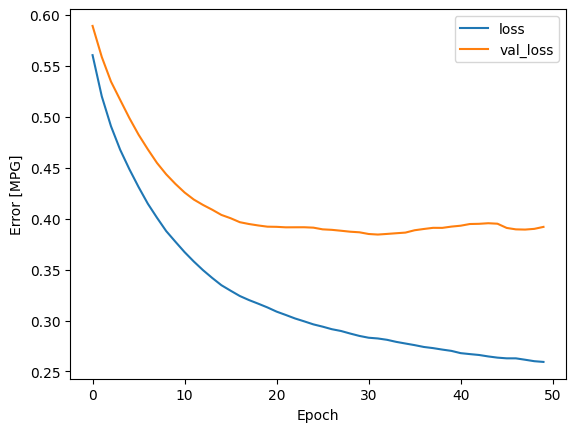

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist['model'] = 'Model_original'

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()

In [32]:
test_loss, test_acc = modelo_original.evaluate(test_ds)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8264 - loss: 0.3963 
Precisión en el conjunto de prueba: 0.8333


In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


In [34]:
def confusion(modelo,mod):
    y_true = []
    y_pred = []

    for x, y in test_ds:
        y_true.extend(y.numpy())  # Guardar etiquetas reales
        y_pred.extend(modelo.predict(x).flatten())  # Obtener predicciones y aplanar

    # Convertir listas a arrays de NumPy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Convertir las predicciones a binario (umbral 0.5)
    y_pred_bin = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    print(f"Verdaderos Negativos (TN): {tn}")
    print(f"Falsos Positivos (FP): {fp}")
    print(f"Falsos Negativos (FN): {fn}")
    print(f"Verdaderos Positivos (TP): {tp}")

    # Cálculo de métricas

    #Accuracy

    acc_ori=(tp+tn)/(tp+tn+fp+fn)
    print("Accuracy de",str(mod)+f" {acc_ori}")

    #Precision

    pre_ori=(tp/(tp+fp)) 
    print("Precisión de",str(mod)+f" {pre_ori}")

    #Valor de predicción negativa

    vpn_ori=tn/(tn+fn)
    print(f"Valor de predicción negativa de",str(mod)+f" {vpn_ori}")

    #Tasa de verdaderos positivos

    recall_ori=tp/(tp+fn)
    print(f"Recall de",str(mod)+f" {recall_ori}")

    # Tasa de verdaderos negativos

    tnr_ori=tn/(fp+tn)
    print(f"Tasa de verdaderos negativos de",str(mod)+f" {tnr_ori}")

    #Tasa de falsos positivos - Error tipo 1

    error1_ori=fp/(fp+tn)
    print(f"Error tipo 1 de",str(mod)+f" {error1_ori}")

    #Tasa de falsos negativos - Error tipo 2

    error2_ori=fn/(fn+tp)
    print(f"Error tipo 2 de",str(mod)+f" {error2_ori}")

    #AUC
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calcular el área bajo la curva (AUC)
    roc_auc = auc(fpr, tpr)

    print(f"Área bajo la curva (AUC): {roc_auc:.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC - '+mod)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Verdaderos Negativos (TN): 34
Falsos Positivos (FP): 2
Falsos Negativos (FN): 8
Verdaderos Positivos (TP): 16
Accuracy de Modelo original 0.8333333333333334
Precisión de Modelo original 0.8888888888888888
Valor de predicción negativa de Modelo original 0.8095238095238095
Recall de Modelo original 0.6666666666666666
Tasa de verdaderos negativos de Modelo original 0.9444444444444444
Error tipo 1 de Modelo original 0.05555555555555555
Error tipo 2 de Modelo original 0.3333333333333333
Área bajo la curva (AUC): 0.9306


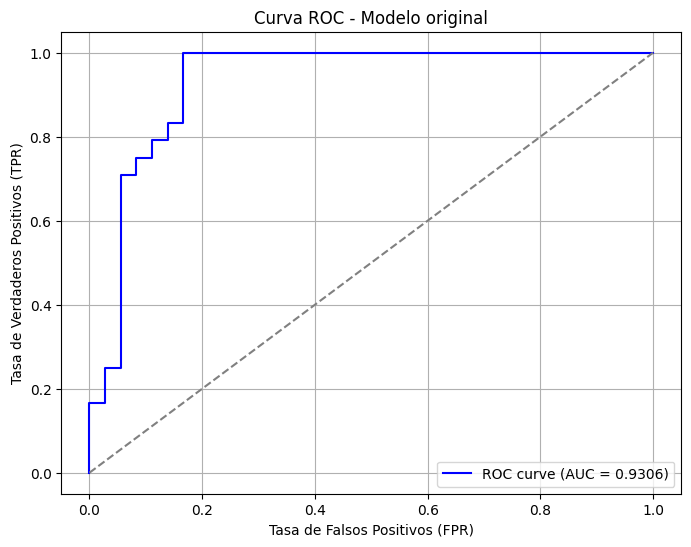

In [35]:
confusion(modelo_original,"Modelo original")


## Cambios de optimizador

Se usó el optimizador SGD y Lion para los siguientes modelos.

In [36]:
model_layers = keras.layers.Dense(32, activation='relu')(all_feats)
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)

modelo = keras.Model(inputs, model_layers)

modelo.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
modelo.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6100 - loss: 0.6541 - val_accuracy: 0.6667 - val_loss: 0.6726
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6231 - loss: 0.6234 - val_accuracy: 0.7083 - val_loss: 0.6628
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6559 - loss: 0.6064 - val_accuracy: 0.6875 - val_loss: 0.6480
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6599 - loss: 0.5940 - val_accuracy: 0.6875 - val_loss: 0.6315
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6765 - loss: 0.5857 - val_accuracy: 0.6667 - val_loss: 0.6104
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7119 - loss: 0.5804 - val_accuracy: 0.6458 - val_loss: 0.5947
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7719 - loss: 0.5368 - val_accuracy: 0.6458 - val_loss: 0.5912
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7354 - loss: 0.5684 - val_accuracy: 0.6875 - val_loss: 0.5781
Epoch 9

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Verdaderos Negativos (TN): 34
Falsos Positivos (FP): 2
Falsos Negativos (FN): 13
Verdaderos Positivos (TP): 11
Accuracy de Modelo con op=SGD 0.75
Precisión de Modelo con op=SGD 0.8461538461538461
Valor de predicción negativa de Modelo con op=SGD 0.723404255319149
Recall de Modelo con op=SGD 0.4583333333333333
Tasa de verdaderos negativos de Modelo con op=SGD 0.9444444444444444
Error tipo 1 de Modelo con op=SGD 0.05555555555555555
Error tipo 2 de Modelo con op=SGD 0.5416666666666666
Área bajo la curva (AUC): 0.9201


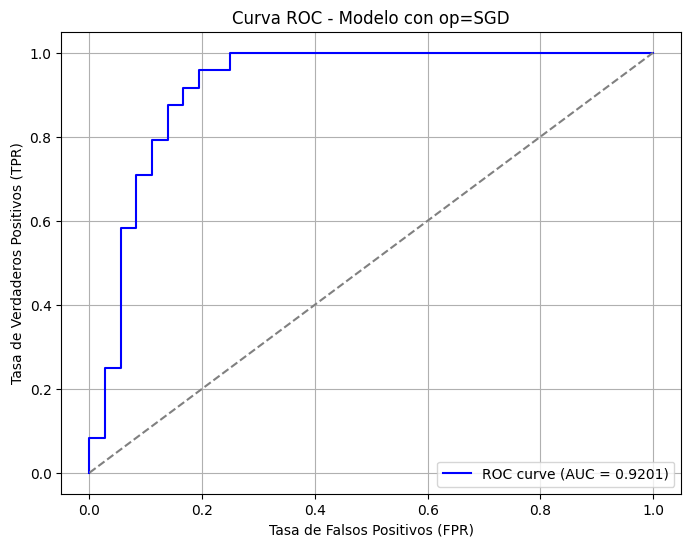

In [37]:
confusion(modelo,"Modelo con op=SGD")

In [38]:
modelo_lion = keras.Model(inputs, model_layers)

modelo_lion.compile(optimizer='lion', loss='binary_crossentropy', metrics=['accuracy'])
modelo_lion.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7944 - loss: 0.3921 - val_accuracy: 0.7500 - val_loss: 0.4367
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8131 - loss: 0.3790 - val_accuracy: 0.7708 - val_loss: 0.4311
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8331 - loss: 0.3328 - val_accuracy: 0.7708 - val_loss: 0.4225
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8220 - loss: 0.3292 - val_accuracy: 0.7708 - val_loss: 0.4137
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8038 - loss: 0.3463 - val_accuracy: 0.7708 - val_loss: 0.4067
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8283 - loss: 0.3149 - val_accuracy: 0.7708 - val_loss: 0.4016
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8538 - loss: 0.3193 - val_accuracy: 0.7708 - val_loss: 0.3972
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8497 - loss: 0.3226 - val_accuracy: 0.8125 - val_loss: 0.3945
Epoch 9/50
7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 10
Verdaderos Positivos (TP): 14
Accuracy de Modelo con Op=Lion 0.7666666666666667
Precisión de Modelo con Op=Lion 0.7777777777777778
Valor de predicción negativa de Modelo con Op=Lion 0.7619047619047619
Recall de Modelo con Op=Lion 0.5833333333333334
Tasa de verdaderos negativos de Modelo con Op=Lion 0.8888888888888888
Error tipo 1 de Modelo con Op=Lion 0.1111111111111111
Error tipo 2 de Modelo con Op=Lion 0.4166666666666667
Área bajo la curva (AUC): 0.9306


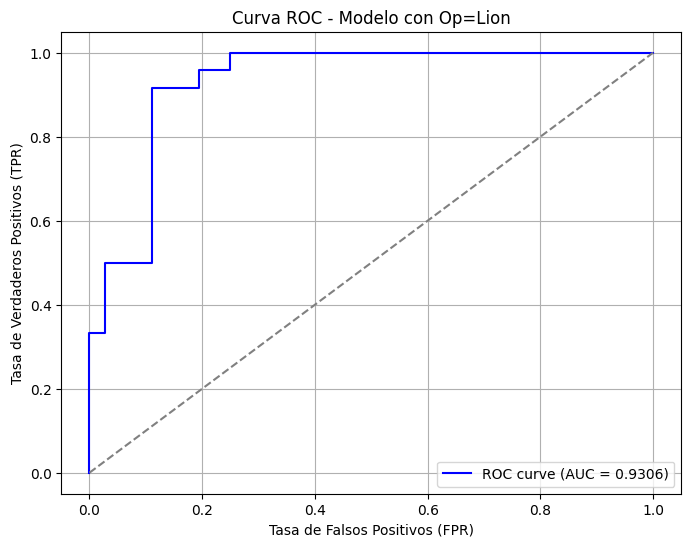

In [39]:
confusion(modelo_lion,'Modelo con Op=Lion')

## Cambios de tasa de aprendizaje

Se modificaron las tasas de aprendizaje en los siguientes modelos usando nuevamente el optimizador Adam

In [40]:
from keras.optimizers import Adam

Primero con una tasa=0.01

In [41]:
modelo41 = keras.Model(inputs, model_layers)

modelo41.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
modelo41.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9189 - loss: 0.1764 - val_accuracy: 0.7917 - val_loss: 0.6412
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9157 - loss: 0.1529 - val_accuracy: 0.7917 - val_loss: 0.6441
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9043 - loss: 0.1603 - val_accuracy: 0.7917 - val_loss: 0.6855
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9364 - loss: 0.1524 - val_accuracy: 0.7917 - val_loss: 0.7117
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9479 - loss: 0.1297 - val_accuracy: 0.7917 - val_loss: 0.7341
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9444 - loss: 0.1186 - val_accuracy: 0.7917 - val_loss: 0.7560
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9348 - loss: 0.1227 - val_accuracy: 0.7917 - val_loss: 0.7663
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9503 - loss: 0.1111 - val_accuracy: 0.7917 - val_loss: 0.7972
Epoch 9/50
7/7 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 10
Verdaderos Positivos (TP): 14
Accuracy de Modelo con tasa de aprendizaje=0.01 0.7666666666666667
Precisión de Modelo con tasa de aprendizaje=0.01 0.7777777777777778
Valor de predicción negativa de Modelo con tasa de aprendizaje=0.01 0.7619047619047619
Recall de Modelo con tasa de aprendizaje=0.01 0.5833333333333334
Tasa de verdaderos negativos de Modelo con tasa de aprendizaje=0.01 0.8888888888888888
Error tipo 1 de Modelo con tasa de aprendizaje=0.01 0.1111111111111111
Error tipo 2 de Modelo con tasa de aprendizaje=0.01 0.4166666666666667
Área bajo la curva (AUC): 0.9086


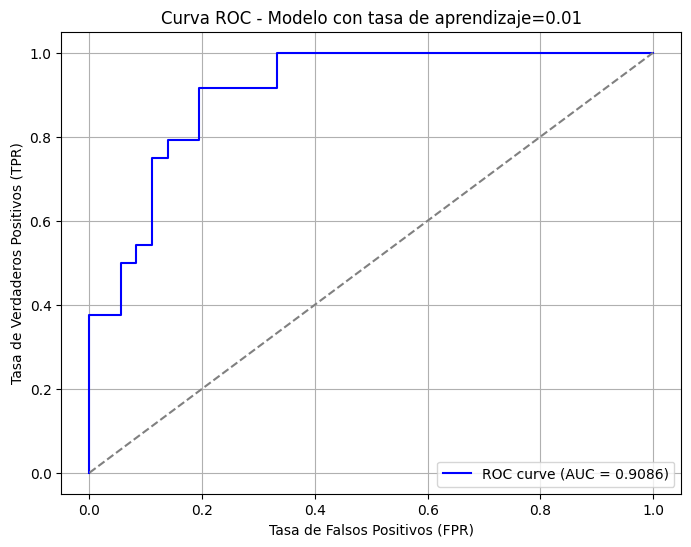

In [42]:
confusion(modelo41,"Modelo con tasa de aprendizaje=0.01")

Ahora con una tasa=0.0001

In [43]:
modelo42 = keras.Model(inputs, model_layers)

modelo42.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
modelo42.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.8125 - val_loss: 1.1514
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0219 - val_accuracy: 0.8125 - val_loss: 1.1524
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0246 - val_accuracy: 0.8125 - val_loss: 1.1531
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0238 - val_accuracy: 0.8125 - val_loss: 1.1538
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0226 - val_accuracy: 0.8125 - val_loss: 1.1545
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.8125 - val_loss: 1.1553
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0216 - val_accuracy: 0.8125 - val_loss: 1.1560
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0219 - val_accuracy: 0.8125 - val_loss: 1.1567
Epoch 9/50
7/7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 10
Verdaderos Positivos (TP): 14
Accuracy de Mod con tasa=0.0001 0.7666666666666667
Precisión de Mod con tasa=0.0001 0.7777777777777778
Valor de predicción negativa de Mod con tasa=0.0001 0.7619047619047619
Recall de Mod con tasa=0.0001 0.5833333333333334
Tasa de verdaderos negativos de Mod con tasa=0.0001 0.8888888888888888
Error tipo 1 de Mod con tasa=0.0001 0.1111111111111111
Error tipo 2 de Mod con tasa=0.0001 0.4166666666666667
Área bajo la curva (AUC): 0.9097


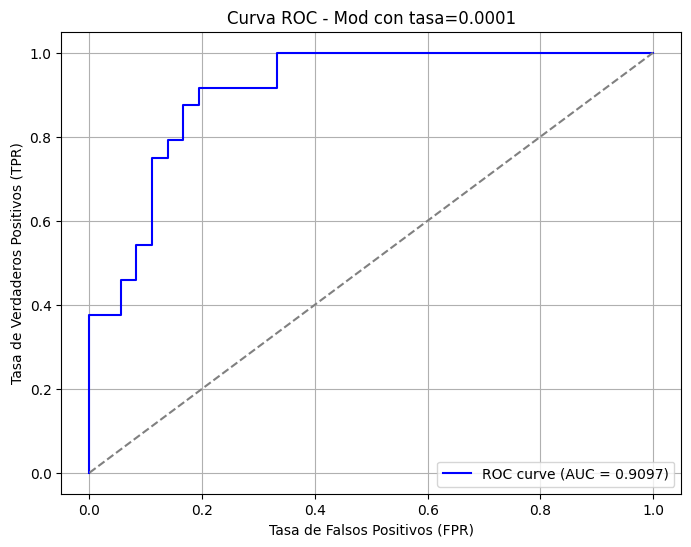

In [44]:
confusion(modelo42,"Mod con tasa=0.0001")

Ahora con una tasa de aprendizaje=0.1

In [45]:
modelo43 = keras.Model(inputs, model_layers)

modelo43.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
modelo43.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9359 - loss: 0.2837 - val_accuracy: 0.8542 - val_loss: 1.0968
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8984 - loss: 0.2470 - val_accuracy: 0.8333 - val_loss: 1.4043
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9160 - loss: 0.2231 - val_accuracy: 0.8333 - val_loss: 1.5027
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9166 - loss: 0.2192 - val_accuracy: 0.8542 - val_loss: 1.0758
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9206 - loss: 0.2494 - val_accuracy: 0.8333 - val_loss: 1.4664
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9205 - loss: 0.1881 - val_accuracy: 0.8125 - val_loss: 0.9402
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9326 - loss: 0.1577 - val_accuracy: 0.8333 - val_loss: 1.1377
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9501 - loss: 0.0939 - val_accuracy: 0.8333 - val_loss: 1.2715
Epoch 9/50
7/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 10
Verdaderos Positivos (TP): 14
Accuracy de Modelo con tasa=0.1 0.7666666666666667
Precisión de Modelo con tasa=0.1 0.7777777777777778
Valor de predicción negativa de Modelo con tasa=0.1 0.7619047619047619
Recall de Modelo con tasa=0.1 0.5833333333333334
Tasa de verdaderos negativos de Modelo con tasa=0.1 0.8888888888888888
Error tipo 1 de Modelo con tasa=0.1 0.1111111111111111
Error tipo 2 de Modelo con tasa=0.1 0.4166666666666667
Área bajo la curva (AUC): 0.8762


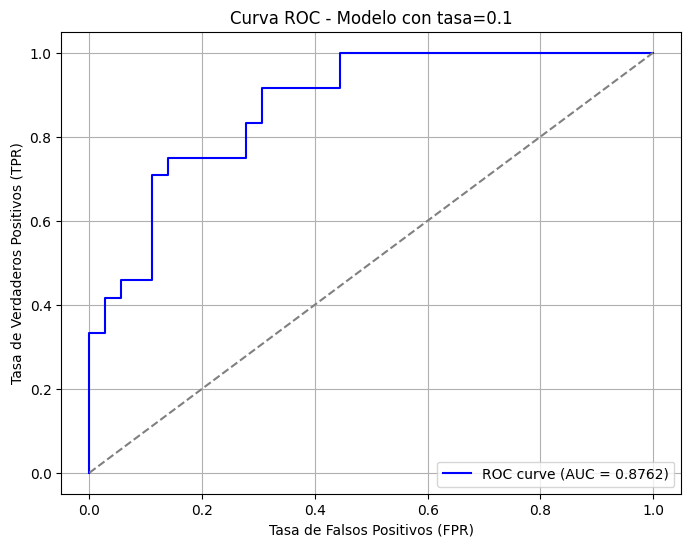

In [46]:
confusion(modelo43,"Modelo con tasa=0.1")

## Cambios en la función de activación

Se cambiara la función de activación, modificando la original que usó relu

In [47]:
model_layers41 = keras.layers.Dense(32, activation='tanh')(all_feats)
model_layers41 = keras.layers.Dense(1, activation='sigmoid')(model_layers)

modelo_41 = keras.Model(inputs, model_layers41)

modelo_41.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelo_41.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7430 - loss: 0.6964 - val_accuracy: 0.7500 - val_loss: 0.6920
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7416 - loss: 0.6939 - val_accuracy: 0.7500 - val_loss: 0.6902
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7704 - loss: 0.6909 - val_accuracy: 0.7500 - val_loss: 0.6884
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7739 - loss: 0.6885 - val_accuracy: 0.7500 - val_loss: 0.6871
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7435 - loss: 0.6872 - val_accuracy: 0.7500 - val_loss: 0.6856
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7578 - loss: 0.6848 - val_accuracy: 0.7500 - val_loss: 0.6843
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7826 - loss: 0.6821 - val_accuracy: 0.7500 - val_loss: 0.6828
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7404 - loss: 0.6813 - val_accuracy: 0.7500 - val_loss: 0.6812
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 11
Verdaderos Positivos (TP): 13
Accuracy de Modelo con activación tanh 0.75
Precisión de Modelo con activación tanh 0.7647058823529411
Valor de predicción negativa de Modelo con activación tanh 0.7441860465116279
Recall de Modelo con activación tanh 0.5416666666666666
Tasa de verdaderos negativos de Modelo con activación tanh 0.8888888888888888
Error tipo 1 de Modelo con activación tanh 0.1111111111111111
Error tipo 2 de Modelo con activación tanh 0.4583333333333333
Área bajo la curva (AUC): 0.8796


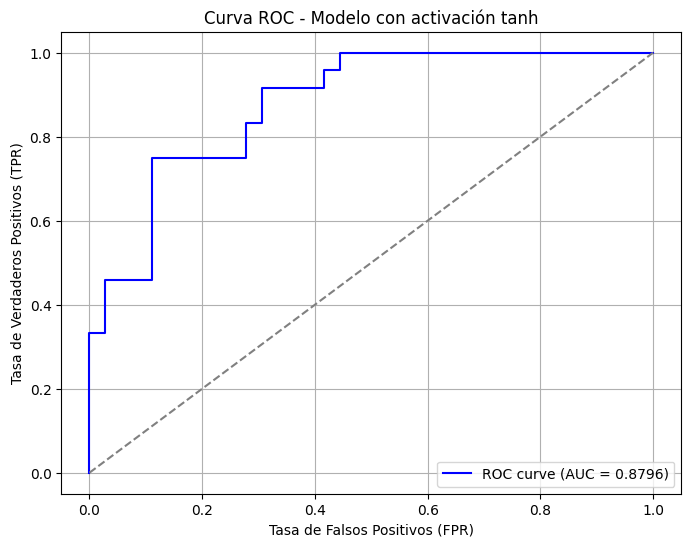

In [48]:
confusion(modelo41,"Modelo con activación tanh")

In [49]:
model_layers42 = keras.layers.Dense(32, activation='mish')(all_feats)
model_layers42 = keras.layers.Dense(1, activation='sigmoid')(model_layers)

modelo_42 = keras.Model(inputs, model_layers42)

modelo_42.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelo_42.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7430 - loss: 0.7492 - val_accuracy: 0.7500 - val_loss: 0.7070
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7712 - loss: 0.7407 - val_accuracy: 0.7500 - val_loss: 0.7059
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7671 - loss: 0.7400 - val_accuracy: 0.7500 - val_loss: 0.7051
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7569 - loss: 0.7409 - val_accuracy: 0.7500 - val_loss: 0.7043
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7503 - loss: 0.7406 - val_accuracy: 0.7500 - val_loss: 0.7032
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7557 - loss: 0.7375 - val_accuracy: 0.7500 - val_loss: 0.7019
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7337 - loss: 0.7407 - val_accuracy: 0.7500 - val_loss: 0.7006
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7836 - loss: 0.7270 - val_accuracy: 0.7500 - val_loss: 0.6992
Epoch 9

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Verdaderos Negativos (TN): 36
Falsos Positivos (FP): 0
Falsos Negativos (FN): 24
Verdaderos Positivos (TP): 0
Accuracy de Modelo con activación mish 0.6
Precisión de Modelo con activación mish nan
Valor de predicción negativa de Modelo con activación mish 0.6
Recall de Modelo con activación mish 0.0
Tasa de verdaderos negativos de Modelo con activación mish 1.0
Error tipo 1 de Modelo con activación mish 0.0
Error tipo 2 de Modelo con activación mish 1.0
Área bajo la curva (AUC): 0.2182


C:\Users\JESUS\AppData\Local\Temp\ipykernel_27700\3386765025.py:31: RuntimeWarning: invalid value encountered in scalar divide
  pre_ori=(tp/(tp+fp))


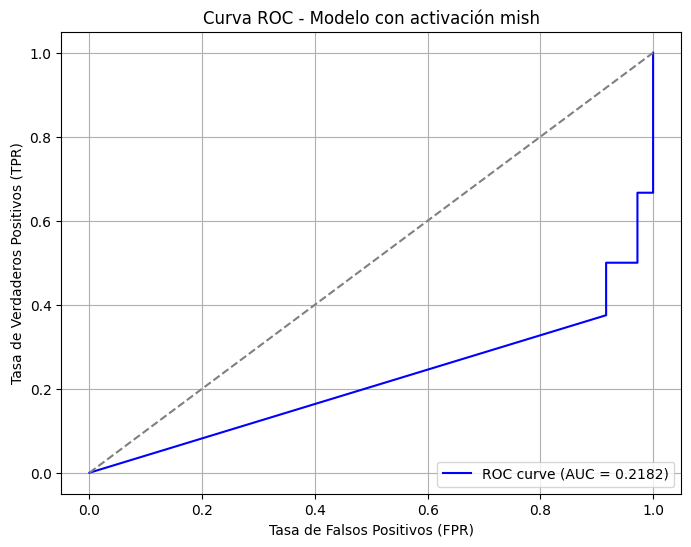

In [50]:
confusion(modelo_42,"Modelo con activación mish")

In [51]:
model_layers43 = keras.layers.Dense(32, activation='gelu')(all_feats)
model_layers43 = keras.layers.Dense(1, activation='sigmoid')(model_layers)

modelo_43 = keras.Model(inputs, model_layers43)

modelo_43.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelo_43.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8987 - loss: 0.6834 - val_accuracy: 0.7917 - val_loss: 0.6760
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8155 - loss: 0.6727 - val_accuracy: 0.7917 - val_loss: 0.6740
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8420 - loss: 0.6746 - val_accuracy: 0.7917 - val_loss: 0.6720
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8257 - loss: 0.6729 - val_accuracy: 0.7917 - val_loss: 0.6701
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8516 - loss: 0.6708 - val_accuracy: 0.7917 - val_loss: 0.6685
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8530 - loss: 0.6653 - val_accuracy: 0.7917 - val_loss: 0.6677
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8543 - loss: 0.6623 - val_accuracy: 0.7917 - val_loss: 0.6675
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8596 - loss: 0.6631 - val_accuracy: 0.7917 - val_loss: 0.6672
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 10
Verdaderos Positivos (TP): 14
Accuracy de Modelo con activación gelu 0.7666666666666667
Precisión de Modelo con activación gelu 0.7777777777777778
Valor de predicción negativa de Modelo con activación gelu 0.7619047619047619
Recall de Modelo con activación gelu 0.5833333333333334
Tasa de verdaderos negativos de Modelo con activación gelu 0.8888888888888888
Error tipo 1 de Modelo con activación gelu 0.1111111111111111
Error tipo 2 de Modelo con activación gelu 0.4166666666666667
Área bajo la curva (AUC): 0.8177


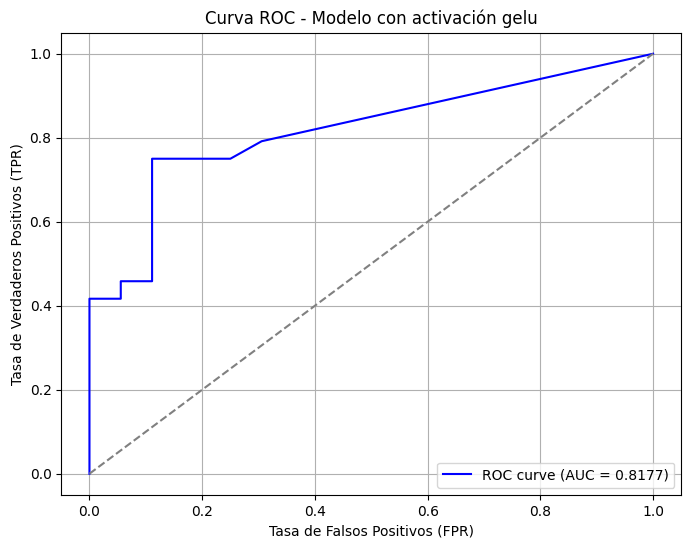

In [52]:
confusion(modelo_43,"Modelo con activación gelu")

## Modelos Propuestos

In [53]:
from keras.optimizers import SGD, Lion



In [54]:
model_layers51 = keras.layers.Dense(32, activation='relu')(all_feats)
model_layers51 = keras.layers.Dense(1, activation='sigmoid')(model_layers)

modelo_51 = keras.Model(inputs, model_layers51)

modelo_51.compile(optimizer=SGD(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

modelo_51.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7439 - loss: 0.8668 - val_accuracy: 0.7500 - val_loss: 0.7446
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7924 - loss: 0.7947 - val_accuracy: 0.7500 - val_loss: 0.7083
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7403 - loss: 0.7851 - val_accuracy: 0.7500 - val_loss: 0.6790
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7713 - loss: 0.7220 - val_accuracy: 0.7500 - val_loss: 0.6629
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7609 - loss: 0.6995 - val_accuracy: 0.7500 - val_loss: 0.6389
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7699 - loss: 0.6592 - val_accuracy: 0.7500 - val_loss: 0.6190
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7470 - loss: 0.6483 - val_accuracy: 0.7500 - val_loss: 0.6022
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7788 - loss: 0.5964 - val_accuracy: 0.7500 - val_loss: 0.5875
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 10
Verdaderos Positivos (TP): 14
Accuracy de Modelo SGD-0.1-Relu 0.7666666666666667
Precisión de Modelo SGD-0.1-Relu 0.7777777777777778
Valor de predicción negativa de Modelo SGD-0.1-Relu 0.7619047619047619
Recall de Modelo SGD-0.1-Relu 0.5833333333333334
Tasa de verdaderos negativos de Modelo SGD-0.1-Relu 0.8888888888888888
Error tipo 1 de Modelo SGD-0.1-Relu 0.1111111111111111
Error tipo 2 de Modelo SGD-0.1-Relu 0.4166666666666667
Área bajo la curva (AUC): 0.8345


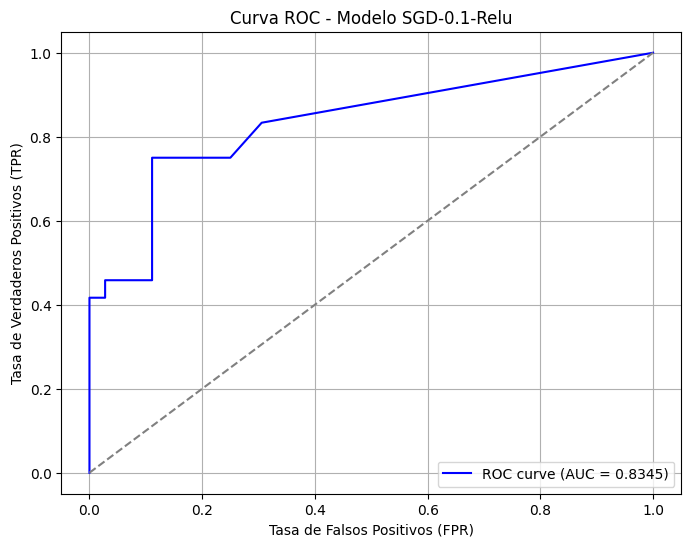

In [55]:
confusion(modelo_51,"Modelo SGD-0.1-Relu")

In [56]:
model_layers52 = keras.layers.Dense(32, activation='tanh')(all_feats)
model_layers52 = keras.layers.Dense(1, activation='sigmoid')(model_layers)

modelo_52 = keras.Model(inputs, model_layers52)

modelo_52.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

modelo_52.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9000 - loss: 0.6724 - val_accuracy: 0.7500 - val_loss: 0.6875
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9961 - loss: 0.6724 - val_accuracy: 0.8125 - val_loss: 0.6874
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9903 - loss: 0.6728 - val_accuracy: 0.8125 - val_loss: 0.6872
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9841 - loss: 0.6742 - val_accuracy: 0.8125 - val_loss: 0.6870
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9880 - loss: 0.6697 - val_accuracy: 0.8125 - val_loss: 0.6869
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9923 - loss: 0.6658 - val_accuracy: 0.8125 - val_loss: 0.6868
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9841 - loss: 0.6709 - val_accuracy: 0.8125 - val_loss: 0.6866
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9900 - loss: 0.6684 - val_accuracy: 0.8125 - val_loss: 0.6864
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Verdaderos Negativos (TN): 32
Falsos Positivos (FP): 4
Falsos Negativos (FN): 7
Verdaderos Positivos (TP): 17
Accuracy de Adam-0.0001-tanH 0.8166666666666667
Precisión de Adam-0.0001-tanH 0.8095238095238095
Valor de predicción negativa de Adam-0.0001-tanH 0.8205128205128205
Recall de Adam-0.0001-tanH 0.7083333333333334
Tasa de verdaderos negativos de Adam-0.0001-tanH 0.8888888888888888
Error tipo 1 de Adam-0.0001-tanH 0.1111111111111111
Error tipo 2 de Adam-0.0001-tanH 0.2916666666666667
Área bajo la curva (AUC): 0.8113


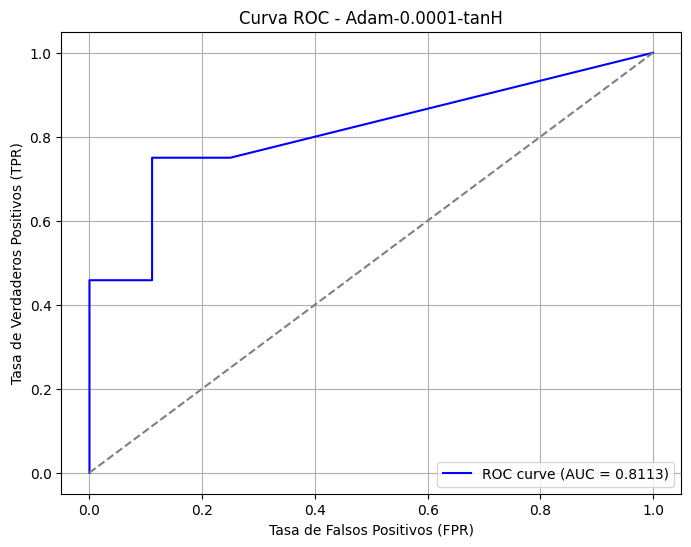

In [58]:
confusion(modelo_52,"Adam-0.0001-tanH")